In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 4090


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS_PHASE1 = 5
EPOCHS_PHASE2 = 10
DATA_DIR = "Dataset" 

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset))

Classes: ['Bacterial Blight', 'Cercospora', 'Healthy Coffee Leaf', 'Healthy Sugarcane Leaf', 'Mosaic', 'RedRot', 'Rust Coffee Leaf', 'Rust Sugarcane Leaf', 'Yellow']
Total images: 4915


In [7]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

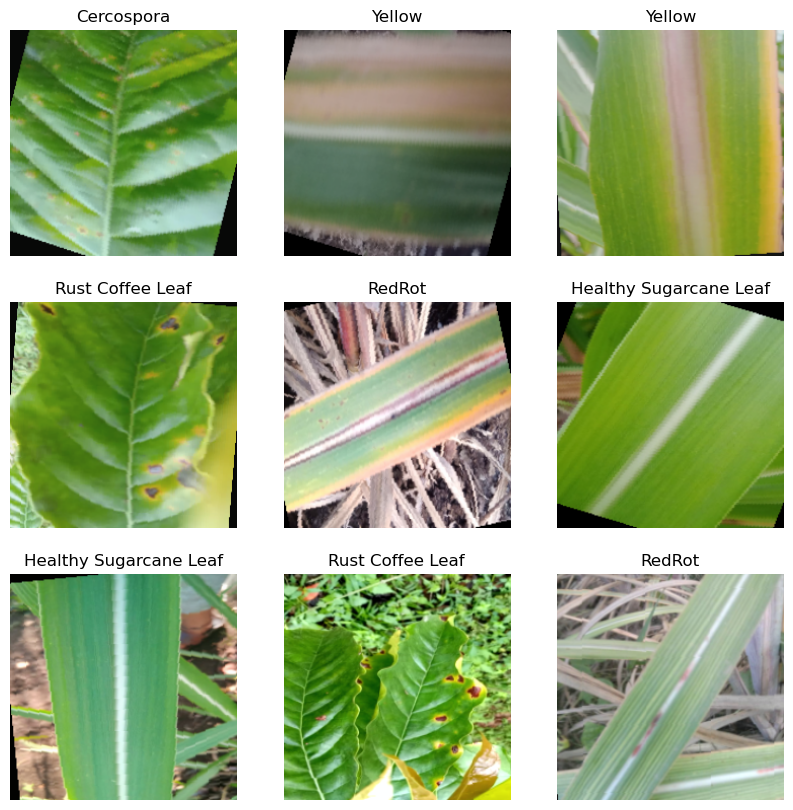

In [9]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                  np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [10]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")

# Freeze all feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for your dataset
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scaler = torch.amp.GradScaler("cuda")

In [12]:
!pip install ipywidgets

In [14]:
from tqdm import tqdm

In [15]:
print("PHASE 1: Training classifier only")

for epoch in range(EPOCHS_PHASE1):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS_PHASE1}", unit="batch")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(train_loss=f"{train_loss/len(train_loader):.4f}",
                                 train_acc=f"{(correct/total)*100:.2f}%")

    # Validation after each epoch
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Clean aligned summary
    print(f"\nEpoch Summary [{epoch+1}/{EPOCHS_PHASE1}]")
    print("-" * 50)
    print(f"{'Train Loss:':15} {train_loss/len(train_loader):.4f}")
    print(f"{'Train Accuracy:':15} {(correct/total)*100:.2f}%")
    print(f"{'Val Loss:':15} {val_loss/len(val_loader):.4f}")
    print(f"{'Val Accuracy:':15} {(val_correct/val_total)*100:.2f}%")
    print("-" * 50 + "\n")

PHASE 1: Training classifier only


Epoch 1/5: 100%|███████████████████████████████| 54/54 [03:12<00:00,  3.56s/batch, train_acc=60.87%, train_loss=1.3828]



Epoch Summary [1/5]
--------------------------------------------------
Train Loss:     1.3828
Train Accuracy: 60.87%
Val Loss:       0.9349
Val Accuracy:   75.99%
--------------------------------------------------



Epoch 2/5: 100%|███████████████████████████████| 54/54 [02:57<00:00,  3.28s/batch, train_acc=77.76%, train_loss=0.8299]



Epoch Summary [2/5]
--------------------------------------------------
Train Loss:     0.8299
Train Accuracy: 77.76%
Val Loss:       0.7000
Val Accuracy:   79.96%
--------------------------------------------------



Epoch 3/5: 100%|███████████████████████████████| 54/54 [02:58<00:00,  3.30s/batch, train_acc=80.64%, train_loss=0.6744]



Epoch Summary [3/5]
--------------------------------------------------
Train Loss:     0.6744
Train Accuracy: 80.64%
Val Loss:       0.6023
Val Accuracy:   81.28%
--------------------------------------------------



Epoch 4/5: 100%|███████████████████████████████| 54/54 [03:00<00:00,  3.34s/batch, train_acc=82.33%, train_loss=0.5965]



Epoch Summary [4/5]
--------------------------------------------------
Train Loss:     0.5965
Train Accuracy: 82.33%
Val Loss:       0.5247
Val Accuracy:   84.03%
--------------------------------------------------



Epoch 5/5: 100%|███████████████████████████████| 54/54 [02:59<00:00,  3.33s/batch, train_acc=82.79%, train_loss=0.5512]



Epoch Summary [5/5]
--------------------------------------------------
Train Loss:     0.5512
Train Accuracy: 82.79%
Val Loss:       0.4785
Val Accuracy:   85.25%
--------------------------------------------------



In [16]:
for param in model.features[-2:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [17]:
print("PHASE 2: Fine-tuning last 2 blocks + classifier")

for epoch in range(EPOCHS_PHASE2):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS_PHASE2}", unit="batch")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(train_loss=f"{train_loss/len(train_loader):.4f}",
                                 train_acc=f"{(correct/total)*100:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Aligned summary
    print(f"\nEpoch Summary [{epoch+1}/{EPOCHS_PHASE2}]")
    print("-" * 50)
    print(f"{'Train Loss:':15} {train_loss/len(train_loader):.4f}")
    print(f"{'Train Accuracy:':15} {(correct/total)*100:.2f}%")
    print(f"{'Val Loss:':15} {val_loss/len(val_loader):.4f}")
    print(f"{'Val Accuracy:':15} {(val_correct/val_total)*100:.2f}%")
    print("-" * 50 + "\n")

PHASE 2: Fine-tuning last 2 blocks + classifier


Epoch 1/10: 100%|██████████████████████████████| 54/54 [02:58<00:00,  3.31s/batch, train_acc=85.49%, train_loss=0.4606]



Epoch Summary [1/10]
--------------------------------------------------
Train Loss:     0.4606
Train Accuracy: 85.49%
Val Loss:       0.3745
Val Accuracy:   88.61%
--------------------------------------------------



Epoch 2/10: 100%|██████████████████████████████| 54/54 [02:57<00:00,  3.29s/batch, train_acc=88.49%, train_loss=0.3699]



Epoch Summary [2/10]
--------------------------------------------------
Train Loss:     0.3699
Train Accuracy: 88.49%
Val Loss:       0.3059
Val Accuracy:   90.44%
--------------------------------------------------



Epoch 3/10: 100%|██████████████████████████████| 54/54 [02:55<00:00,  3.26s/batch, train_acc=90.55%, train_loss=0.2981]



Epoch Summary [3/10]
--------------------------------------------------
Train Loss:     0.2981
Train Accuracy: 90.55%
Val Loss:       0.2966
Val Accuracy:   90.13%
--------------------------------------------------



Epoch 4/10: 100%|██████████████████████████████| 54/54 [02:55<00:00,  3.26s/batch, train_acc=91.45%, train_loss=0.2619]



Epoch Summary [4/10]
--------------------------------------------------
Train Loss:     0.2619
Train Accuracy: 91.45%
Val Loss:       0.2441
Val Accuracy:   92.17%
--------------------------------------------------



Epoch 5/10: 100%|██████████████████████████████| 54/54 [02:56<00:00,  3.28s/batch, train_acc=92.82%, train_loss=0.2277]



Epoch Summary [5/10]
--------------------------------------------------
Train Loss:     0.2277
Train Accuracy: 92.82%
Val Loss:       0.2330
Val Accuracy:   91.86%
--------------------------------------------------



Epoch 6/10: 100%|██████████████████████████████| 54/54 [02:57<00:00,  3.29s/batch, train_acc=93.23%, train_loss=0.2048]



Epoch Summary [6/10]
--------------------------------------------------
Train Loss:     0.2048
Train Accuracy: 93.23%
Val Loss:       0.2300
Val Accuracy:   91.66%
--------------------------------------------------



Epoch 7/10: 100%|██████████████████████████████| 54/54 [02:57<00:00,  3.30s/batch, train_acc=93.31%, train_loss=0.1950]



Epoch Summary [7/10]
--------------------------------------------------
Train Loss:     0.1950
Train Accuracy: 93.31%
Val Loss:       0.2159
Val Accuracy:   92.57%
--------------------------------------------------



Epoch 8/10: 100%|██████████████████████████████| 54/54 [02:58<00:00,  3.30s/batch, train_acc=93.43%, train_loss=0.1874]



Epoch Summary [8/10]
--------------------------------------------------
Train Loss:     0.1874
Train Accuracy: 93.43%
Val Loss:       0.1879
Val Accuracy:   93.69%
--------------------------------------------------



Epoch 9/10: 100%|██████████████████████████████| 54/54 [02:58<00:00,  3.30s/batch, train_acc=94.51%, train_loss=0.1664]



Epoch Summary [9/10]
--------------------------------------------------
Train Loss:     0.1664
Train Accuracy: 94.51%
Val Loss:       0.2025
Val Accuracy:   94.20%
--------------------------------------------------



Epoch 10/10: 100%|█████████████████████████████| 54/54 [02:58<00:00,  3.30s/batch, train_acc=94.77%, train_loss=0.1574]



Epoch Summary [10/10]
--------------------------------------------------
Train Loss:     0.1574
Train Accuracy: 94.77%
Val Loss:       0.2143
Val Accuracy:   93.18%
--------------------------------------------------



In [18]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Final Test Accuracy:", (correct / total) * 100, "%")

Final Test Accuracy: 93.90243902439023 %


In [19]:
# Create Models folder if not present
model_folder = "Models"
os.makedirs(model_folder, exist_ok=True)

# Count existing models to determine next name
existing_models = [f for f in os.listdir(model_folder) if f.startswith("Model") and f.endswith(".pth")]
next_model_number = len(existing_models) + 1
model_filename = f"Model{next_model_number}.pth"

save_path = os.path.join(model_folder, model_filename)

# Save model + class names
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, save_path)

print(f"Model saved successfully as {save_path}")

Model saved successfully as Models\Model1.pth
